## Packages and Purpose

In [58]:
import string
import os
import numpy as np
import keras

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras import regularizers

import tensorflow as tf
import transformers
from sklearn.linear_model import LogisticRegression

Classification of Reuters news articles by topic.  Useful for Reuters' analytics in providing niche customers (e.g., those in the cocoa industry, see below) with targeted articles about their space.  The same idea is useful in Reuters' legal operations, as follows: for a customer engaged in a legal dispute relating to one of its products (e.g. from the FTC, or e.g. Apple v. Samsung), helpful to sort through e-mails and other internal documents relevant to that product if a red-team analysis is conducted.

## Text Extraction and Exploratory Data Analysis

In [63]:
base_dir = '/Users/Goursat/Documents/Reuters'

In [64]:
# data obtained from UCI repo
# local file path

folder = os.path.join(base_dir,'reuters21578') 

In [65]:
#os.listdir(folder)
#around twenty .sgm files, each containing multiple articles

In [66]:
example = open(os.path.join(folder, 'reut2-009.sgm'), encoding = 'utf8', errors = 'ignore').read()

In [67]:
# need to extract the article's topics and text
# note that many articles lack a topic
print(example)

<!DOCTYPE lewis SYSTEM "lewis.dtd">
<REUTERS TOPICS="NO" LEWISSPLIT="TRAIN" CGISPLIT="TRAINING-SET" OLDID="14522" NEWID="9001">
<DATE>24-MAR-1987 15:59:17.10</DATE>
<TOPICS></TOPICS>
<PLACES><D>usa</D></PLACES>
<PEOPLE></PEOPLE>
<ORGS></ORGS>
<EXCHANGES></EXCHANGES>
<COMPANIES></COMPANIES>
<UNKNOWN> 
&#5;&#5;&#5;F
&#22;&#22;&#1;f2412&#31;reute
u f BC-ADVANCED-MAGNETICS-&lt;A   03-24 0066</UNKNOWN>
<TEXT>&#2;
<TITLE>ADVANCED MAGNETICS &lt;ADMG> IN AGREEMENT</TITLE>
<DATELINE>    CAMBRIDGE, Mass., March 24 - </DATELINE><BODY>Advanced Magnetics Inc said it
reached a four mln dlrs research and development agreement with
ML TEchnolgy Ventures LP, a limited partnership sponsored by
Merrill LYnch Capital Markets.
    Under the agreement, Advanced Magnetics will develop and
conducts clinical trials of its contrast agents for magnetic
resonance imaging.
    The agreement includes a warrant permitting MLTV to buy up
to 380,000 shares of Advanced Magnetics common stock through
February 1994 at 10

In [68]:
# containers for article topics and bodies

article_topics = []
article_bodies = []

# topic counts dictionary to store topic frequency

topic_counts = {}

In [69]:
# load the data from disparate .sgm files into topic, bodies, and topic_counts containers

# text tag ending each of the article bodies
reuters = 'Reuter\n&#3;'


for fname in sorted(os.listdir(folder)):
    if 'sgm' in fname:
        data = open(os.path.join(folder, fname), encoding = 'utf8', errors = 'ignore').read()
        topic_begin = '<TOPICS>'
        topic_end = '</TOPICS>'
        body_tag = '<BODY>'
        
        while topic_begin in data:
            data = data[data.find(topic_begin) + len(topic_begin):]
            topic = data[:data.find(topic_end)]
            if topic and '</D><D>' not in topic: # non-empty, single label
                topic = topic.replace('<D>', '').replace('</D>','')
                article_topics.append(topic)
                topic_counts[topic] = topic_counts.get(topic, 0) + 1
            else:
                continue # ignore non-empty or multi-label articles
                
            body = data[data.find(body_tag) + len(body_tag):]
            body = body[: body.find('</') - len(reuters)] # further remove 'Reuter\n&#3;'
            body.replace('\n', '')
            article_bodies.append(body)

In [70]:
print(len(topic_counts), len(article_bodies))

66 9494


In [71]:
print(article_bodies[0])

Showers continued throughout the week in
the Bahia cocoa zone, alleviating the drought since early
January and improving prospects for the coming temporao,
although normal humidity levels have not been restored,
Comissaria Smith said in its weekly review.
    The dry period means the temporao will be late this year.
    Arrivals for the week ended February 22 were 155,221 bags
of 60 kilos making a cumulative total for the season of 5.93
mln against 5.81 at the same stage last year. Again it seems
that cocoa delivered earlier on consignment was included in the
arrivals figures.
    Comissaria Smith said there is still some doubt as to how
much old crop cocoa is still available as harvesting has
practically come to an end. With total Bahia crop estimates
around 6.4 mln bags and sales standing at almost 6.2 mln there
are a few hundred thousand bags still in the hands of farmers,
middlemen, exporters and processors.
    There are doubts as to how much of this cocoa would be fit
for export 

In [72]:
article_topics[0]

'cocoa'

In [73]:
topic_counts

{'cocoa': 63,
 'earn': 3945,
 'acq': 2362,
 'copper': 54,
 'housing': 18,
 'money-supply': 161,
 'coffee': 116,
 'sugar': 143,
 'trade': 361,
 'reserves': 53,
 'ship': 158,
 'cotton': 26,
 'grain': 51,
 'crude': 408,
 'nat-gas': 45,
 'cpi': 79,
 'interest': 285,
 'money-fx': 307,
 'alum': 50,
 'tin': 30,
 'gold': 99,
 'strategic-metal': 19,
 'retail': 22,
 'ipi': 49,
 'oilseed': 9,
 'iron-steel': 47,
 'rubber': 41,
 'heat': 14,
 'jobs': 55,
 'lei': 14,
 'bop': 32,
 'gnp': 83,
 'zinc': 16,
 'veg-oil': 37,
 'orange': 22,
 'carcass': 11,
 'pet-chem': 21,
 'gas': 22,
 'wpi': 26,
 'livestock': 20,
 'lumber': 12,
 'instal-debt': 7,
 'meal-feed': 7,
 'lead': 8,
 'potato': 5,
 'nickel': 4,
 'inventories': 3,
 'cpu': 4,
 'l-cattle': 1,
 'silver': 11,
 'fuel': 11,
 'jet': 4,
 'income': 12,
 'rand': 1,
 'platinum': 3,
 'dlr': 6,
 'stg': 1,
 'wool': 1,
 'tea': 6,
 'groundnut': 2,
 'rice': 1,
 'yen': 6,
 'hog': 1,
 'naphtha': 1,
 'propane': 1,
 'coconut': 1}

In [74]:
# retain only those topics that appear more than COUNT_THRESHOLD times

# our learning algorithm will only be able to provide predictions on a given class
# with suitable training data available for the same

COUNT_THRESHOLD = 30 # must have >= this many samples of a given topic to retain this topic

In [75]:
retained_topics = []
retained_bodies = []

retained_counts = {}

In [76]:
for x in topic_counts.keys():
    if topic_counts[x] >= COUNT_THRESHOLD:
        retained_counts[x] = topic_counts[x]

In [77]:
for i in range(len(article_topics)):
    if retained_counts.get(article_topics[i], 0) != 0:
        retained_topics.append(article_topics[i])
        retained_bodies.append(article_bodies[i])

In [78]:
print(len(retained_counts), len(retained_bodies))

26 9114


In [79]:
NUMBER_CATEGORIES = len(retained_counts)

In [80]:
NUMBER_CATEGORIES

26

In [81]:
# plot the class distributions

# huge class imbalance, with 'acq' and 'earn' classes constituting the vast majority
# of news articles

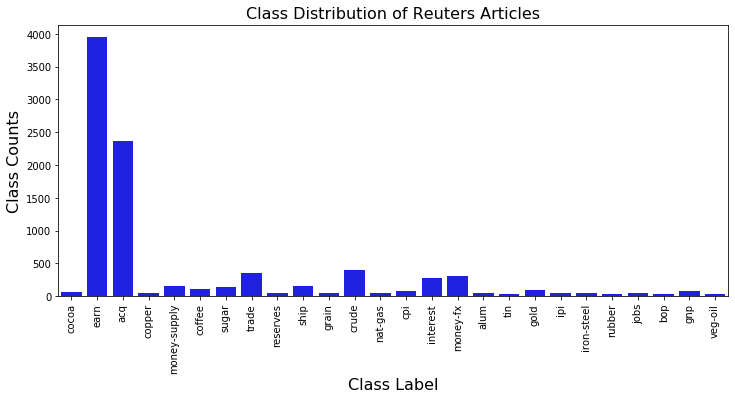

In [82]:
plt.figure(figsize=(12,5))
sns.countplot(x = retained_topics, color = 'blue')
plt.title('Class Distribution of Reuters Articles', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

In [83]:
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None, # uses wordcloud's default stopwords
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [84]:
# combine all the text from 'acq' and 'earn' articles, then pass the same to wordcloud

acq_text = ''
for i in range(len(retained_topics)):
    if retained_topics[i] == 'acq':
        acq_text += retained_bodies[i]
        
earn_text = ''
for i in range(len(retained_topics)):
    if retained_topics[i] == 'earn':
        earn_text += retained_bodies[i]
    

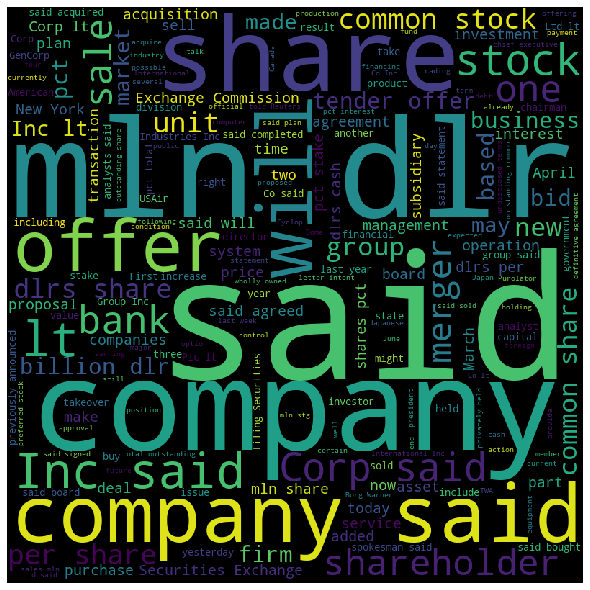

In [85]:
plot_word_cloud(acq_text)

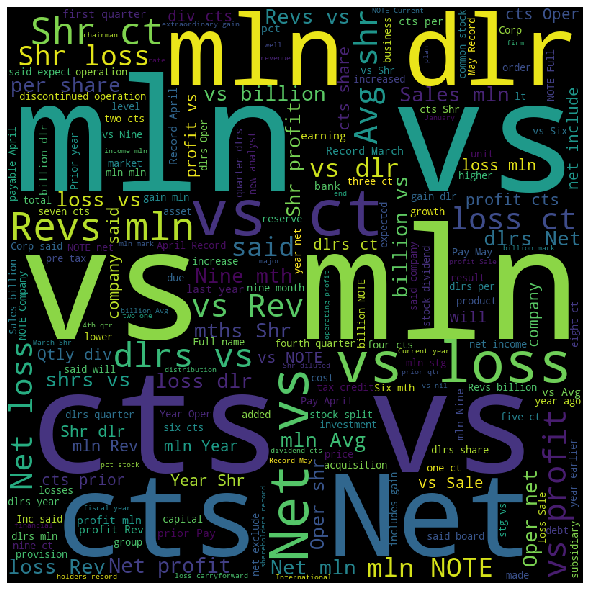

In [86]:
plot_word_cloud(earn_text)

## Preprocessing and Word Frequency Tokenization

Now we tokenize our data, replacing words with their frequency relative to the total data set.

In [87]:
WORD_THRESHOLD = 10000 # only retain the 10,000 most common words

In [ ]:
tokenizer = Tokenizer(num_words = WORD_THRESHOLD) # Keras utility function

In [ ]:
tokenizer.fit_on_texts(retained_bodies)

In [ ]:
tokenized_bodies = tokenizer.texts_to_sequences(retained_bodies)

In [ ]:
tokenized_bodies = np.array(tokenized_bodies)

In [ ]:
tokenized_bodies[0]

Transform inputs via one-hot encoding, mapping a list of integers in the range [1, WORD_THRESHOLD] to a vector of length WORD_THRESHOLD with values 0 or 1 at the k-th entry depending upon the absence or presence of k in our list.  Note that word order is lost.

In [ ]:
def one_hot_encoding(sequences, dimension = WORD_THRESHOLD):
    result = np.zeros((len(sequences), dimension))
    for i in range(len(sequences)):
        for j in range(len(sequences[i])):
            if sequences[i][j] < dimension:
                result[i, sequences[i][j]] = 1
    return result

In [ ]:
inputs = one_hot_encoding(tokenized_bodies)

In [ ]:
inputs[0]

Next we tokenize and vectorize our output labels.  First, we map the output labels to integer values.  Then, outputs are transformed using the to_categorical utility function, mapping an integral class label k to a vector of length NUMBER_CATEGORIES with the k-th entry set to one and the remaining entries set to zero.

In [ ]:
temp = list(retained_counts.keys())

In [ ]:
labels_to_categories = {}

In [ ]:
for i in range(len(temp)):
    labels_to_categories[temp[i]] = i

In [ ]:
#labels_to_categories

In [ ]:
for i in range(len(retained_topics)):
    retained_topics[i] = labels_to_categories.get(retained_topics[i])

In [ ]:
outputs = np.array(retained_topics)

In [ ]:
outputs[0:10]

In [ ]:
outputs = to_categorical(outputs)

In [ ]:
outputs[0]

Randomly assign 30% of the dataset as validation data, training on the remainder.

In [ ]:
training_inputs, validation_inputs, training_outputs, validation_outputs =\
train_test_split(inputs, outputs, test_size = .3)

In [ ]:
print(training_inputs.shape, validation_inputs.shape)

## Dense Neural Network Model

In [ ]:
DNN = models.Sequential()
DNN.add(layers.Dense(64, activation = 'relu', 
                       kernel_regularizer =  regularizers.l2(.001),
                       input_shape = (WORD_THRESHOLD,)))
DNN.add(layers.Dense(64, activation = 'relu', 
                      kernel_regularizer= regularizers.l2(.001)))
DNN.add(layers.Dense(NUMBER_CATEGORIES, activation = 'softmax'))

In [ ]:
DNN.compile(optimizer = 'rmsprop', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

The network is densely connected, with two intermediate layers each having 64 nodes. In each intermediate layer, we use the rectified linear unit ('relu') activation function.

Observe the softmax activation function in our final network layer, an appropriate choice for a multiclass classification model. In addition, note the use of the categorical cross-entropy loss function and the accuracy performance metric in the .compile() parameter list.  Other performance metric choices include precision and recall.

To combat overfitting, we add regularization terms to the model, which add the norm-squared of layer weight terms to the loss function specified below.  We could instead reduce the network size or add drop-out terms to the network (see e.g. denseNN_binaryclass.ipynb).

In [ ]:
EPOCHS = 20

outcome = DNN.fit(training_inputs, training_outputs, epochs = EPOCHS, batch_size = 256,
         validation_data = (validation_inputs, validation_outputs))

In [ ]:
#outcome.history.keys()

In [ ]:
epochs = range(1, EPOCHS + 1)
accuracy = outcome.history.get('accuracy')
val_accuracy = outcome.history.get('val_accuracy')

In [ ]:
plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plot above shows a monotonic increase in training accuracy and an increase and mild decline in validation accuracy.  This behavior can also be seen in the callbacks generated by the .fit() method above.  The model appears to be overfitting the training data as we iterate over more and more epochs.  One way to combat this overfitting is to partially train the model, halting training at an early epoch (say, the eleventh epoch).  Further steps beyond this early stopping and our earlier use of regularization include adding drop-out terms to the network (see e.g. denseNN_binaryclass.ipynb) or decreasing the network size.  

In [ ]:
DNN.evaluate(test_inputs, test_outputs_alt)

In [93]:
MAX_LEN = 512

In [88]:
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [133]:
def fast_encode(text, tokenizer, maxlen = MAX_LEN):
    return np.array(tokenizer.encode(text, max_length = maxlen, pad_to_max_length = True, add_special_tokens = True))

In [134]:
tokenized_bodies = np.zeros((len(retained_bodies), MAX_LEN))

In [135]:
for i in range(len(retained_bodies)):
    tokenized_bodies[i, :] = fast_encode(retained_bodies[i], tokenizer)

In [136]:
tokenized_bodies = tokenized_bodies.astype('int32')

In [137]:
tokenized_bodies.shape

(9114, 512)

In [138]:
config = transformers.DistilBertConfig()

In [139]:
model = transformers.TFDistilBertModel(config).from_pretrained('distilbert-base-uncased')

In [142]:
eg = model.predict(tokenized_bodies[0])

In [152]:
eg.shape

(512, 1, 768)

In [154]:
eg[0, 0, :].shape

(768,)

In [155]:
fedthrough_data = np.zeros((tokenized_bodies.shape[0], 768))

In [158]:
fedthrough_data[0].shape

(768,)

In [ ]:
for i in range(tokenized_bodies.shape[0]):
    fedthrough_data[i] = model.predict(tokenized_bodies[i])[0, 0, :]

In [ ]:
temp = list(retained_counts.keys())

In [ ]:
labels_to_categories = {}

In [ ]:
for i in range(len(temp)):
    labels_to_categories[temp[i]] = i

In [ ]:
for i in range(len(retained_topics)):
    retained_topics[i] = labels_to_categories.get(retained_topics[i])

In [ ]:
outputs = np.array(retained_topics)

In [ ]:
outputs = to_categorical(outputs)

In [ ]:
training_inputs, validation_inputs, training_outputs, validation_outputs =\
train_test_split(fedthrough_data, outputs, test_size = .3)

In [ ]:
toplayerClassifier = LogisticRegression()

In [ ]:
toplayerClassifier.fit(training_inputs, training_outputs)

In [ ]:
toplayerClassifier.score(validation_inputs, validation_outputs)

Next we try a different feature representation, so-called TF-IDF weighting with words weighted by term frequency multiplied by inverse data frequency (actually, the log of data frequency).  In this way, we include words that might be rarely seen within documents but also rarely seen among documents.  These sorts of words, which can be thought of as key words for their respective categories (and are therefore of great predictive value), are ignored in the earlier analysis, where we only consider the WORD_THRESHOLD most common words.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
DIMENSION = 100

In [ ]:
vectorizer = TfidfVectorizer(max_features = DIMENSION)

In [ ]:
inputs_tfidf = vectorizer.fit_transform(retained_article_bodies)

In [ ]:
inputs_tfidf.shape

In [ ]:
test_tfidf = inputs_tfidf[8000:,:]
validation_tfidf = inputs_tfidf[6000:8000,:]
training_tfidf = inputs_tfidf[:6000,:]

In [ ]:
print(test_tfidf.shape, validation_tfidf.shape, training_tfidf.shape)

In [ ]:
LRM = LogisticRegression()

In [ ]:
LRM.fit(training_tfidf, training_outputs_alt)

In [ ]:
LRM.score(test_tfidf, test_outputs_alt)

In [ ]:
DNN = models.Sequential()
DNN.add(layers.Dense(64, activation = 'relu', 
                       kernel_regularizer =  regularizers.l2(.001),
                       input_shape = (DIMENSION,)))
DNN.add(layers.Dense(64, activation = 'relu', 
                      kernel_regularizer= regularizers.l2(.001)))
DNN.add(layers.Dense(NUMBER_CATEGORIES, activation = 'softmax'))

In [ ]:
DNN.compile(optimizer = 'rmsprop', 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
EPOCHS = 20

outcome = DNN.fit(training_tfidf, training_outputs, epochs = EPOCHS, batch_size = 256,
         validation_data = (validation_tfidf, validation_outputs))

In [ ]:
import xgboost as xgb

In [ ]:
XGBC = xgb.XGBClassifier()

In [ ]:
XGBC.fit(training_tfidf, training_outputs_alt)

In [ ]:
XGBC.score(test_tfidf, test_outputs_alt)